In [1]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline


In [2]:
def scrape(link):
    r = requests.get(link)
    soup = bs(r.content)
    
    html_table = soup.find("table", attrs={"class": "table"})
    
    
    html_values = html_table.find_all("tr", attrs={"class": "team"})
    values = [[get_text(v.string) for v in v_list.find_all('td')] for v_list in html_values]
    
    return insert_values(values, table)
    

In [ ]:
table = scrape('https://www.scrapethissite.com/pages/forms/?page_num=2')


# Scraping

## Exemplificando para a primeira aba

### Obtenção dos dados

In [3]:
# Importando a página

r = requests.get('https://www.scrapethissite.com/pages/forms/')

soup = bs(r.content)


In [4]:
# Extraindo a Tabela desejada

html_table = soup.find("table", attrs={"class": "table"})


In [5]:
def get_text(content):
    '''
    Recebe strings com comandos \n indesejáveis e espaços vazios
    
    Retorna a string tratada
    
    Ex: print(get_text('\n  água é bom\n    '))
        'água é bom'
    '''
    return " ".join(content.replace('\n', "").split())


### Transformando a tabela HTML em um DataFrame

In [6]:
# Extaindo as chaves

html_keys = html_table.find("tr").find_all("th")

keys = [get_text(k.string) for k in html_keys]


In [7]:
# Extraindo os valores

html_values = html_table.find_all("tr", attrs={"class": "team"})

'''
Dentro de cada item da lista html_values estão os times. Para um time em específico,
encontramos suas propriedades com o .find_all("td") e, por fim, extraímos o texto.
'''

values = [[get_text(v.string) for v in v_list.find_all('td')] for v_list in html_values]


In [8]:
# Criando o DataFrame

table = pd.DataFrame()

for k in keys:
    table[k] = []
table


,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -


In [9]:
# Incluindo os valores ao DataFrame

def insert_values(rows, df):
    for v_list in rows:
        s = pd.Series(data=v_list, index=keys)
        row = pd.DataFrame([s])
        df = pd.concat([df, row], ignore_index=True)
        #for z in list(zip(keys, v_list)):
    return df

table = insert_values(values, table)


In [10]:
table.head()


,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
0,Boston Bruins,1990,44,24,,0.55,299,264,35
1,Buffalo Sabres,1990,31,30,,0.388,292,278,14
2,Calgary Flames,1990,46,26,,0.575,344,263,81
3,Chicago Blackhawks,1990,49,23,,0.613,284,211,73
4,Detroit Red Wings,1990,34,38,,0.425,273,298,-25


## Scraping de todas as abas

In [11]:
for i in range(2, 25):
    l = 'https://www.scrapethissite.com/pages/forms/?page_num=' + str(i)
    table = scrape(l)


In [12]:
table = table.astype({'+ / -': 'int8', 'Wins': 'int8', 'Losses': 'int8', 'Year': 'int16', 
                      'Goals For (GF)': 'int16', 'Goals Against (GA)': 'int16', 'Win %': 'float64'})


In [13]:
table.loc[table['Team Name'] == 'Nashville Predators'].head()


,Team Name,Year,Wins,Losses,OT Losses,Win %,Goals For (GF),Goals Against (GA),+ / -
210,Nashville Predators,1998,28,47,,0.341,190,261,-71
238,Nashville Predators,1999,28,40,7,0.341,199,240,-41
268,Nashville Predators,2000,34,36,3,0.415,186,200,-14
298,Nashville Predators,2001,28,41,0,0.341,196,230,-34
328,Nashville Predators,2002,27,35,7,0.329,183,206,-23


## Dados da ESPN

In [14]:
table_espn = pd.read_csv('DataSet ESPN.csv')
table_espn = table_espn.drop(['Unnamed: 0'], axis = 1)
table_espn.head()


,Team,Home Games,Home Total,Home Average,Road Games,Road Average,Overall Games,Overall Average,Year,Save Percentage,Penalty Minutes,Penalty Minutes Against
0,Montreal Canadiens,41,"824,308","20,105",41,"16,013",82,"18,059",2001,0.899,1020,1294
1,Detroit Red Wings,41,"819,795","19,995",41,"17,889",82,"18,942",2001,0.909,1082,1072
2,Philadelphia Flyers,41,"802,595","19,575",41,"17,182",82,"18,378",2001,0.903,1183,1332
3,St Louis Blues,41,"800,319","19,519",41,"16,898",82,"18,209",2001,0.899,1345,1366
4,Toronto Maple Leafs,41,"789,567","19,257",41,"17,172",82,"18,215",2001,0.908,1430,1243


In [15]:
# Corringindo os valores com vírgula

table_espn['Home Total'] = table_espn['Home Total'].str.replace(',','')
table_espn['Home Average'] = table_espn['Home Average'].str.replace(',','')
table_espn['Road Average'] = table_espn['Road Average'].str.replace(',','')
table_espn['Overall Average'] = table_espn['Overall Average'].str.replace(',','')
table_espn = table_espn.astype({'Home Games': 'int8', 'Road Games': 'int8', 'Overall Games': 'int8', 
                               'Home Total': 'int32', 'Home Average': 'int16', 'Road Average': 'int16', 
                               'Overall Average': 'int16', 'Year': 'int16', 'Penalty Minutes': 'int16', 
                               'Penalty Minutes Against': 'int16'})


In [16]:
# Corrigindo os nomes dos times

table_espn.loc[table_espn['Team'] == 'St Louis Blues', 'Team'] = 'St. Louis Blues'
table_espn.loc[table_espn['Team'] == 'Minnesota North Stars', 'Team'] = 'Minnesota Wild'
table.loc[table['Team Name'] == 'Hartford Whalers', 'Team Name'] = 'Carolina Hurricanes'
table.loc[table['Team Name'] == 'Quebec Nordiques', 'Team Name'] = 'Colorado Avalanche'
table.loc[table['Team Name'] == 'Winnipeg Jets', 'Team Name'] = 'Phoenix Coyotes'
table.loc[table['Team Name'] == 'Atlanta Thrashers', 'Team Name'] = 'Calgary Flames'
table.loc[table['Team Name'] == 'Anaheim Ducks', 'Team Name'] = 'Mighty Ducks of Anaheim'
table.loc[table['Team Name'] == 'Minnesota North Stars', 'Team Name'] = 'Dallas Stars'


# Análise dos dados

## Variações temporais

Esportes não são estáticos, com o passar do tempo a tendência é a profissionalzação do cenário e dos atletas. Até mesmo no xadrez os jogadores evoluíram suas técnicas e modos de jogo com o tempo.

### Quais foram os anos mais acirrados?

Os campeonatos da NHL são disputados com as fases de pontos corridos e eliminatória. Os dados que foram extraídos representam apenas os jogos das fase de pontos corridos, portanto não descrevem verdadeiramente o resultado final daquele ano. Porém, limitando nossa visão apenas ao que temos, podemos criar uma medida para campeonatos acirrados.

Definimos um campeonato como mais acirrado quanto menor for a variância dos valores de porcentagem de vitória dos times naquele ano.

#### Separando informações úteis

In [17]:
# Criação de um data frame específico

disputed_df = pd.DataFrame()
disputed_df['Year'] = table['Year'].unique()


In [18]:
# Cálculo da variância

var_per_year = np.array([])
for year in table['Year'].unique():
    var = table.loc[table['Year'] == year].sort_values(by='Win %', ascending=False)['Win %'].var()
    
    var_per_year = np.append(var_per_year, var)
disputed_df['Variance'] = var_per_year
disputed_df.head()


,Year,Variance
0,1990,0.012258
1,1991,0.008999
2,1992,0.018790
3,1993,0.010203
4,1994,0.013447


In [19]:
def NormalizeSeries(S):
    '''
    Retorna um array da série recebida com valores normalizados.
    '''
    m = S.mean()
    std = S.std()
    return (S.to_numpy() - m)/std
    

In [20]:
# Normalização

disputed_df['Norm Variance'] = -NormalizeSeries(disputed_df['Variance'])
disputed_df['Norm GF'] = NormalizeSeries(table.groupby('Year').mean()['Goals For (GF)'])


In [21]:
PMI_year_df = pd.DataFrame()
PMI_year_df['Year'] = table_espn['Year'].unique()

PMI_year_df['Norm PMI'] = NormalizeSeries(table_espn.groupby('Year').mean()['Penalty Minutes'])


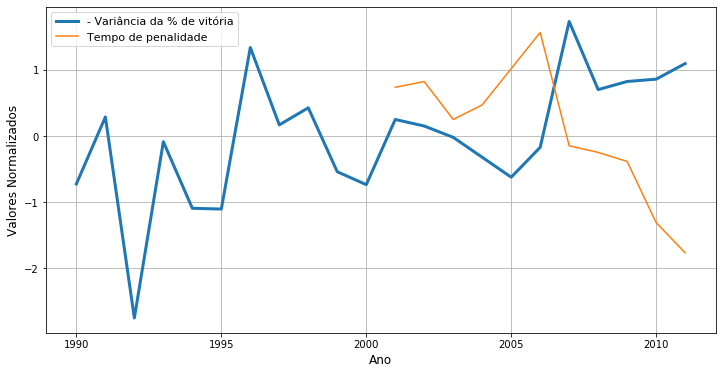

In [22]:
plt.figure(figsize=(12,6))
plt.plot(disputed_df['Year'], disputed_df['Norm Variance'], linewidth=3, label='- Variância da % de vitória')
plt.plot(PMI_year_df['Year'], PMI_year_df['Norm PMI'], label = 'Tempo de penalidade')
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Valores Normalizados', fontsize=12)
plt.legend(fontsize=11)
plt.grid()
plt.show();


Por mais que nossos dados sejam limitados, é possível identificar que os jogos vem ficando lentamente mais acirrados. É curioso que o tempo de penalidade em média tenha diminuido nos últimos anos, já que o uso do termo "acirrado" passa uma ideia diferente.

### Qual a tendência do engajamento do público?

Assim como na análise anterior vamos precisar definir o que chamamos de engajamento do público:

 - Queremos medir o quanto os fãs de hockey no gelo estão dispostos a acompanhar seu time, então faz sentido que o valor absoluto do público não seja o fator chave.
 - As medidas além do valor total que podemos usar dizem a respeito do público que acompanha os times mesmo quando estes não jogam em casa.

Definiremos assim, engajamento como sendo a razão entre a quantidade de acompanhantes fora de casa e a dentro de casa.

In [64]:
eng_df = pd.DataFrame()
home = table_espn.groupby('Year').mean()['Home Average']
road = table_espn.groupby('Year').mean()['Road Average']

eng_df['Engagement'] = (road/home)


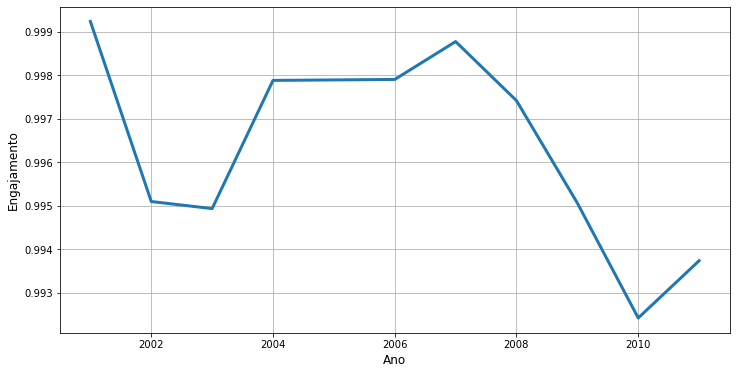

In [68]:
plt.figure(figsize = (12,6))
plt.plot(table_espn['Year'].unique(), eng_df['Engagement'], linewidth = 3)
plt.xlabel('Ano', fontsize = 12)
plt.ylabel('Engajamento', fontsize = 12)
plt.grid()
plt.plot();


Limitando nossa visão mais uma vez ao período de 2001-2011, a tendência que observamos é de uma maior discrepância entre a quantidade de público fora e dentro de casa, principalmente a partir de 2007. Podemos inferir que o advento das redes e a facilidade do acesso a informação desincentivaram a ida de torcedores até as quadras adversárias acompanhar seu time.

## Análise atemporal

Tirar conclusões sobre o esporte sem a divisão temporal, dividindo por times ou fatores por exemplo.

### Quais times ganham mais? Ofensivos ou defensivos?

Essa é uma das perguntas mais naturais a se fazer, e para respondê-lá é preciso certo cuidado, não é só porque um time recebe menos gols que a média que ele é necessariamente defensivo, pode ser o caso de seu ataque ser tão bom que o jogo nem chega ao seu lado defensivo.

O seguinte método pode ser útil para uma resposta menos enviesada:

* Calcula-se a média de gols em cada ano
* Para cada ano, verifica-se qual a porcentagem para mais ou para menos que o valor do time naquele ano representa da média
* Para cada ano, o time recebe uma classificação de comportamento de 0 (Neutro), 1 (Ofensivo) ou -1 (Defensivo) se a porcentagem do item anterior esteja entre 10% para mais ou para menos, 10% para mais ou 10% para menos respectivamente.
* Obtem-se a média total do comportamento de cada time.

A divisão anual serve para compararmos a relação ataque-defesa em seus ambientes isolados, já que eventos de outros anos podem alterar essa relação.

In [111]:
behavior_df = pd.DataFrame()

behavior_df['Team'], behavior_df['Year'], behavior_df['Win %'] = table['Team Name'], table['Year'], table['Win %']

behavior_df['GF relative to Average %'] = table['Goals For (GF)']
behavior_df['GA relative to Average %'] = table['Goals Against (GA)']

for idx, row in table.groupby(['Year']).mean().iterrows():
    behavior_df.loc[behavior_df['Year'] == idx, 'GF relative to Average %'] = (
        behavior_df.loc[behavior_df['Year'] == idx, 'GF relative to Average %'] 
        - row['Goals For (GF)'])/row['Goals For (GF)']
    behavior_df.loc[behavior_df['Year'] == idx, 'GA relative to Average %'] = (
        behavior_df.loc[behavior_df['Year'] == idx, 'GA relative to Average %'] 
        - row['Goals Against (GA)'])/row['Goals Against (GA)']


In [121]:
def team_behavior(gf, ga):
    if -0.1 < gf-ga < 0.1:
        return 0 # Time neutro
    if 0.1 <= gf -ga:
        return 1 # Time ofensivo
    return -1 # Time defensivo


In [122]:
behavior_df['Behavior'] = (time_df['GF relative to Average %']-time_df['GA relative to Average %']
                          ).apply(lambda x: team_behavior(x,0))


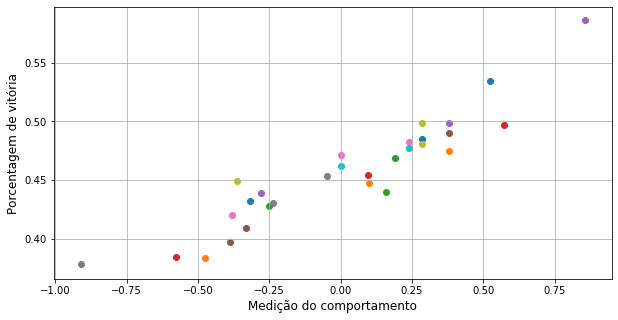

In [130]:
plt.figure(figsize = (10, 5))
for t in behavior_df['Team'].unique():
    team_stats = behavior_df.loc[time_df['Team'] == t].mean()
    plt.scatter(team_stats['Behavior'], team_stats['Win %'])
plt.xlabel('Medição do comportamento', fontsize = 12)
plt.ylabel('Porcentagem de vitórias', fontsize = 12)
plt.grid()
plt.show()


Vemos que times mais ofensivos tendem a se classificar melhor no geral, a baixa variação no eixo vertical para um dado intervalo de comportamento apenas enfatiza essa relação.

### Um time que faz mais faltas também recebe mais?

Por mais que os tempos de falta variem bastante de acordo com o ano ou com o time, é intuitivo pensar que se um time comete muitas faltas, o adversário irá reagir também cometendo outras. Pode-se medir isso pela razão do tempo de faltas cometidas pelo de faltas sofridas.

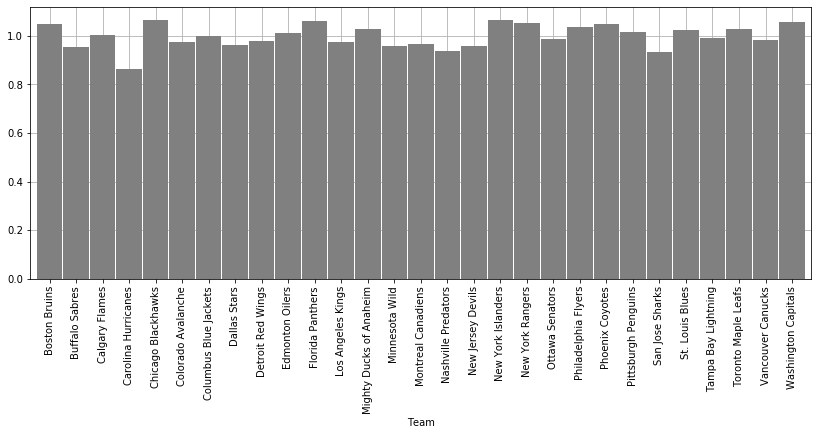

In [200]:
PMI_PMIA = table_espn.groupby(['Team']).mean()
PMI_PMIA['PMI / PMIA'] = PMI_PMIA['Penalty Minutes'] / PMI_PMIA['Penalty Minutes Against']
PMI_PMIA.groupby('Team').mean()['PMI / PMIA'].plot(kind = 'bar', width = 0.962, figsize=(14,5), zorder = 2, color = 'gray')
plt.grid()
plt.xlabel('Time', fontsize = 12)
plt.ylabel('Faltas cometidas / Faltas sofridas')
plt.show();

Como esperado a razão não distoa muito da igualdade, exceto pelos Carolina Hurricanes que parecem ser um pouco odiados e recebem consideravelmente mais faltas do que cometem.

### Como os times se saem no tempo extra?

Para uma última análise, qual time é o mais perigoso no tempo extra? Quais são aqueles que se cansam mais fácil e é bom enrolar o jogo?

In [158]:
# Anos com a regra do tempo extra
ot_df = table.loc[table['Year'] >= 1999].astype({'OT Losses': 'int8'})


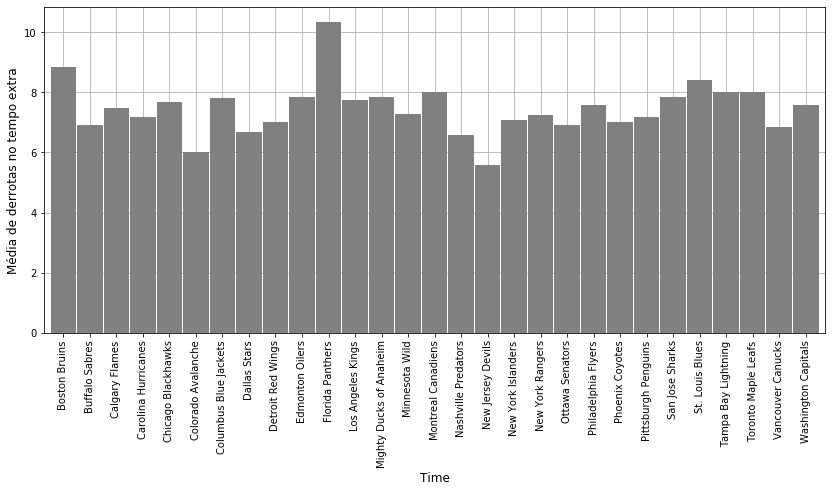

In [204]:
ot_df.groupby('Team Name').mean()['OT Losses'].plot(kind = 'bar', width = 0.966, figsize = (14,6), zorder = 2, color = 'gray')
plt.grid()
plt.ylabel('Média de derrotas no tempo extra', fontsize = 12)
plt.xlabel('Time', fontsize = 12)
plt.show();


Se eu fosse você evitaria levar o jogo para o tempo extra contra os New Jersey Devils, e enrolaria bastante contra os Florida Panthers. 